In [308]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [309]:
# Machine learning modules

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [310]:
# Read clinical trials data 
file_path = 'C:./data/vaccine_trials.csv'
vaccine_trials = pd.read_csv(file_path, index_col = 0)

# Filter completed studies
vax_trials_filtered = vaccine_trials[vaccine_trials['OverallStatus'] == 'Completed']
vax_trials_filtered

# Drop 'Rank' column
vax_trials_filtered.drop('Rank', axis=1, inplace=True)

# Display the DataFrame
vax_trials_filtered.head()

c:\Users\Bruna Los\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,NCTId,Phase,Condition,EnrollmentCount,OverallStatus
0,NCT00478816,Phase 2,Prophylaxis of Avian Influenza Vaccine,58,Completed
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed
3,NCT03057483,NaN,Influenza Vaccines,533,Completed
4,NCT00735410,Phase 3,"Seasonal Influenza, Vaccine",134,Completed
5,NCT00103116,Phase 2,Lung Cancer,32,Completed



### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download)
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [311]:
# Read drop_withdrawals file from AACT database
file_path = 'C:./data/drop_withdrawal.txt'

# select only the nct_id, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,6])

# Rename nct_id column to NCTId 
drop_withdrawals = drop_withdrawals.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
drop_withdrawals.head()

,NCTId,reason,count
0,NCT01443026,Physician Decision,1.0
1,NCT01443026,Physician Decision,0.0
2,NCT01443026,Death,0.0
3,NCT01443026,Death,1.0
4,NCT01443026,Withdrawal by Subject,0.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [312]:
# Read milestones file from AACT database
file_path = 'C:./data/milestones.txt'

# select only the nct_id, title, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[1,4,7])

# Rename nct_id column to NCTId 
milestones = milestones.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
milestones.head()

,NCTId,title,count
0,NCT02829723,STARTED,5.0
1,NCT02829723,STARTED,7.0
2,NCT03907579,STARTED,100.0
3,NCT03074500,STARTED,11.0
4,NCT03074500,STARTED,11.0


#### Exploring the data

In [313]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
vax_trials_with_dropouts = pd.merge(vax_trials_filtered, drop_withdrawals, on='NCTId')
vax_trials_with_dropouts.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,reason,count
0,NCT02915302,Phase 4,Influenza,1950,Completed,Adverse Event,3.0
1,NCT02915302,Phase 4,Influenza,1950,Completed,Adverse Event,0.0
2,NCT02915302,Phase 4,Influenza,1950,Completed,Protocol Violation,20.0
3,NCT02915302,Phase 4,Influenza,1950,Completed,Protocol Violation,27.0
4,NCT02915302,Phase 4,Influenza,1950,Completed,Lost to Follow-up,19.0


In [314]:
# Rename columns for clarity
vax_trials_with_dropouts = vax_trials_with_dropouts.rename(columns={'reason':'Reason', 'count':'DropoutCount'})
vax_trials_with_dropouts.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Reason,DropoutCount
0,NCT02915302,Phase 4,Influenza,1950,Completed,Adverse Event,3.0
1,NCT02915302,Phase 4,Influenza,1950,Completed,Adverse Event,0.0
2,NCT02915302,Phase 4,Influenza,1950,Completed,Protocol Violation,20.0
3,NCT02915302,Phase 4,Influenza,1950,Completed,Protocol Violation,27.0
4,NCT02915302,Phase 4,Influenza,1950,Completed,Lost to Follow-up,19.0


In [315]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
vax_trials_with_milestones = pd.merge(vax_trials_filtered, milestones, on='NCTId')
vax_trials_with_milestones.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,title,count
0,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,STARTED,32.0
1,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,COMPLETED,31.0
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,NOT COMPLETED,1.0
3,NCT00103116,Phase 2,Lung Cancer,32,Completed,STARTED,32.0
4,NCT00103116,Phase 2,Lung Cancer,32,Completed,COMPLETED,32.0


In [316]:
# Rename columns for better clarity
vax_trials_with_milestones = vax_trials_with_milestones.rename(columns={'title':'Status', 'count':'StatusCount'})
vax_trials_with_milestones.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Status,StatusCount
0,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,STARTED,32.0
1,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,COMPLETED,31.0
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,NOT COMPLETED,1.0
3,NCT00103116,Phase 2,Lung Cancer,32,Completed,STARTED,32.0
4,NCT00103116,Phase 2,Lung Cancer,32,Completed,COMPLETED,32.0


In [345]:
# Check for duplicates
duplicates = vax_trials_with_dropouts.duplicated()
print(duplicates.value_counts())

False    1873
dtype: int64


In [343]:
# Remove the duplicates
vax_trials_with_dropouts = vax_trials_with_dropouts.drop_duplicates()

In [346]:
# Print information about the DataFrame
vax_trials_with_dropouts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 0 to 2808
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NCTId            1873 non-null   object 
 1   Phase            1864 non-null   object 
 2   Condition        1873 non-null   object 
 3   EnrollmentCount  1873 non-null   int64  
 4   OverallStatus    1873 non-null   object 
 5   Reason           1873 non-null   object 
 6   DropoutCount     1873 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 117.1+ KB


In [347]:
# Count unique events per column
unique_counts = vax_trials_with_dropouts.nunique()
unique_counts

NCTId              218
Phase                7
Condition          123
EnrollmentCount    196
OverallStatus        1
Reason              99
DropoutCount       106
dtype: int64

In [348]:
# Count NaN values per column
nan_counts = vax_trials_with_dropouts.isna().sum()
nan_counts

NCTId              0
Phase              9
Condition          0
EnrollmentCount    0
OverallStatus      0
Reason             0
DropoutCount       0
dtype: int64

In [349]:
# Summary statistics

#vax_trials_with_dropouts.describe(include = 'all')
vax_trials_with_dropouts.describe()

,EnrollmentCount,DropoutCount
count,1873.000000,1873.000000
mean,2798.538708,15.555793
std,8014.212327,131.292654
min,1.000000,0.000000
25%,449.000000,1.000000
50%,817.000000,2.000000
75%,2055.000000,5.000000
max,84496.000000,3006.000000


In [350]:
# Inspect only one NCT study

one_study = vax_trials_with_milestones[vax_trials_with_milestones['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Status,StatusCount
2964,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,STARTED,181.0
2965,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,STARTED,89.0
2966,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,COMPLETED,176.0
2967,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,COMPLETED,86.0
2968,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,NOT COMPLETED,5.0
2969,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,NOT COMPLETED,3.0


In [351]:
one_study = vax_trials_with_dropouts[vax_trials_with_dropouts['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Reason,DropoutCount
2805,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,adverse event,1.0
2806,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,adverse event,0.0
2807,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,withdrawal,4.0
2808,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,withdrawal,3.0


### Cleaning the data

- standardize the values in your column by converting them all to the same format

In [325]:
unique_names = vax_trials_with_dropouts['Reason'].unique()
unique_names

array(['Adverse Event', 'Protocol Violation', 'Lost to Follow-up',
       'Withdrawal by Subject', 'Other', 'Death', 'Administrative reason',
       'Missing primary reason', 'Serious Adverse Event',
       'Administrative Reasons', 'Unable to Classify',
       'Unable to classify', 'Administrative Reason',
       'Physician Decision', 'Move from study area',
       'To militarycamp for conscript', 'To drug therapy course',
       'Move to work oversea', 'Premature Withdrawal',
       'Father in hospital', 'Migrated/moved from study area',
       'Off study due to infection', 'Inappropriate enrollment',
       'Non-compliance with the protocol',
       'Subject met exclusion criteria',
       'Visit 1 delayed, unable to reschedule',
       'Met exclusion criterion No 6', 'Subject moved out of the state',
       'Baseline measles measure high', 'Did not receive allocation',
       'Insufficient blood sample', 'Not Eligible',
       'Received 2 doses of vaccine',
       'Enrolled both ye

In [326]:
# convert all the strings in the 'reason' column to lowercase

vax_trials_with_dropouts['Reason'] = vax_trials_with_dropouts['Reason'].str.lower()

In [327]:
# Define a mapping dictionary
mapping = {
    'adverse events': 'adverse event',
    'administrative reasons': 'administrative reason',
    'adverse event or death': 'ae or death',
    'failure to return': 'failed to return'
}

# Apply the mapping to the column
vax_trials_with_dropouts['Reason'] = vax_trials_with_dropouts['Reason'].replace(mapping)

In [328]:
# Define the mapping dictionary
mapping = {
    'move': 'relocate',
    'moved': 'relocate',
    'other': 'others',
    'exclusion': 'met exclusion criteria',
    'non compliance': 'protocol violation/deviation',
    'violation': 'protocol violation/deviation',
    'deviation': 'protocol violation/deviation',
    'physician decision': 'physician decision',
    'adverse event': 'adverse event',
    'withdrawal': 'withdrawal',
    'died ': 'death'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_dropouts.loc[vax_trials_with_dropouts['Reason'].str.contains(old_value), 'Reason'] = new_value


#### Analysis

- define functions

In [329]:
# define function to sum the values in the 'count' column
def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [330]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


- Visualize the distribution of clinical trials by phase


In [364]:
# Get value counts for the Phase column
phase_counts = vax_trials_filtered['Phase'].value_counts()
phase_counts

Phase 3            173
Phase 2            146
Phase 1            142
Phase 4            113
Not Applicable      45
Phase 1|Phase 2     26
Phase 2|Phase 3     18
Early Phase 1        3
Name: Phase, dtype: int64

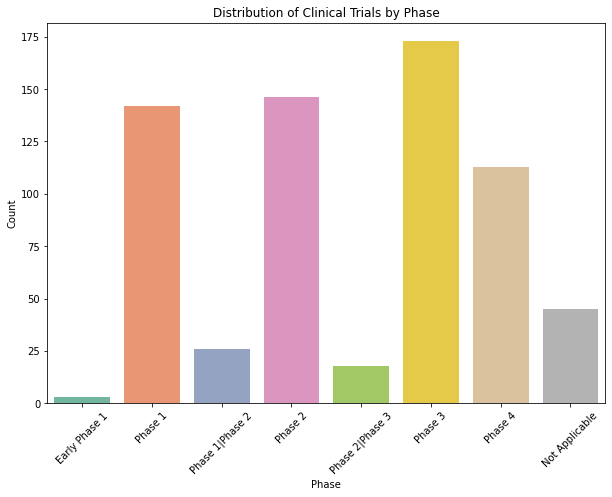

In [366]:
# Plot the distribution of clinical trials by phase

# Select only 'NCTId' and 'Phase' columns
phase_df = vax_trials_filtered[['NCTId', 'Phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Early Phase 1', 'Phase 1', 'Phase 1|Phase 2', 'Phase 2', 'Phase 2|Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='Phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [332]:
# use the 'sum_count' function to select the 'Reason' and 'DropoutCount' columns and sum the values in the 'DropoutCount' column

reason_sum = sum_count(vax_trials_with_dropouts, 'Reason', 'DropoutCount')
reason_sum.head()

,Reason,TotalSum
0,administrative reason,241.0
1,adverse event,563.0
2,ae or death,28.0
3,baseline measles measure high,3.0
4,baseline measure non-negative,73.0


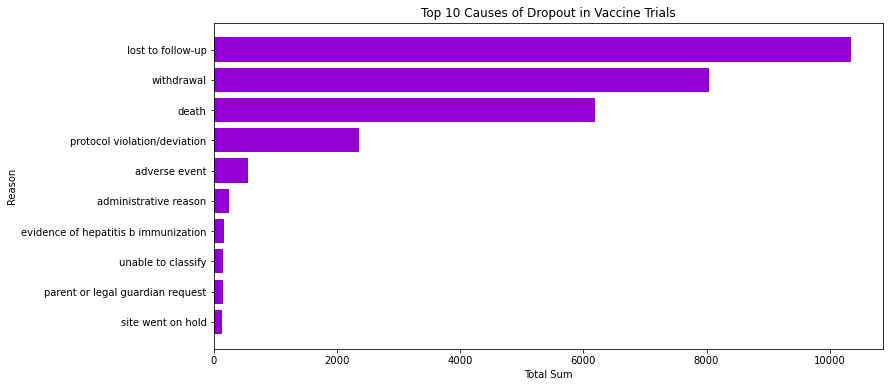

In [333]:
# Plot
dataframe = reason_sum
x_column = 'Reason'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


- Identifying prevalent conditions in vaccine clinical trials

In [355]:
# Select only 'NCTId' and 'Condition' columns
condition_df = vax_trials_filtered[['NCTId', 'Condition']]
condition_df = condition_df.drop_duplicates()
condition_df

,NCTId,Condition
0,NCT00478816,Prophylaxis of Avian Influenza Vaccine
2,NCT03771157,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...
3,NCT03057483,Influenza Vaccines
4,NCT00735410,"Seasonal Influenza, Vaccine"
5,NCT00103116,Lung Cancer
...,...,...
994,NCT00430521,Influenza|Influenza Vaccines
995,NCT01062477,Diphtheria|Tetanus|Pertussis|Haemophilus Influ...
996,NCT02236052,Virus Diseases|RNA Virus Infections|Respirator...
997,NCT03357276,Metastatic Colorectal Cancer|Reaction - Mixed ...


In [356]:
# Calculate the total count for each condition
condition_counts = condition_df['Condition'].value_counts().reset_index()

# Rename the columns for clarity
condition_counts.columns = ['Condition', 'TotalCount']

# Display the resulting DataFrame
condition_counts.head()

,Condition,TotalCount
0,Influenza,116
1,Healthy,16
2,Meningococcal Disease,10
3,"Influenza, Human",10
4,COVID-19,9


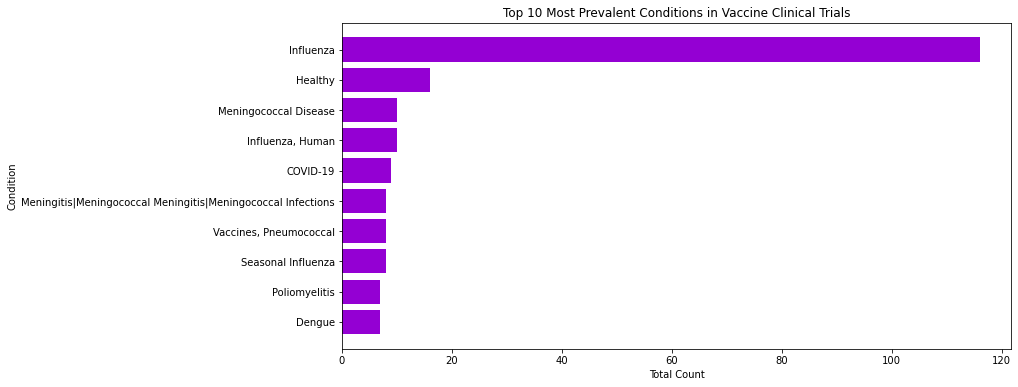

In [359]:
# Plot

dataframe = condition_counts
x_column = 'Condition'
y_column = 'TotalCount'
title = 'Top 10 Most Prevalent Conditions in Vaccine Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Condition'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Determine the prevalence of vaccines utilized as interventions in clinical trials by identifying the most frequently administered ones.

In [360]:
# use the 'sum_count' function to select the 'Condition' and 'EnrollmentCount' columns and sum the values in the 'EnrollmentCount' column

condition_sum = sum_count(vax_trials_filtered, 'Condition', 'EnrollmentCount')
condition_sum.head()

,Condition,TotalSum
0,- HIV,24
1,13-valent Pneumococcal Vaccine|Immunization|Sa...,263
2,2009 H1N1 Influenza Virus,34
3,Acellular Pertussis|Diphtheria|Poliomyelitis|H...,403
4,Acute Myeloid Leukemia|Acute Lymphoblastic Leu...,22


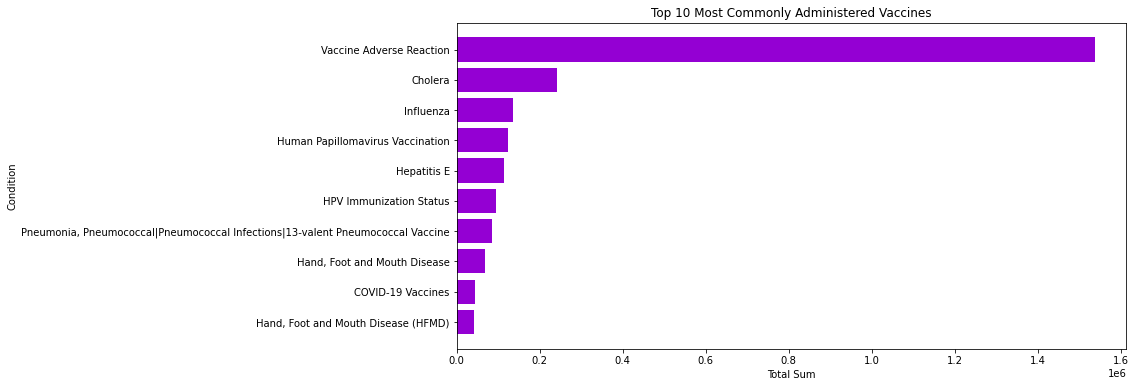

In [361]:
# Plot
dataframe = condition_sum
x_column = 'Condition'
y_column = 'TotalSum'
title = 'Top 10 Most Commonly Administered Vaccines'
xlabel = 'Total Sum'
ylabel = 'Condition'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)

- Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [337]:
# use the 'sum_count' function to select the 'Status' and 'Count' columns and sum the values in the 'Count' column

status_sum = sum_count(vax_trials_with_milestones, 'Status', 'StatusCount')
status_sum.head()

,Status,TotalSum
0,Baseline Negative,1460.0
1,Baseline Negative With Outside Vaccination Cen...,1331.0
2,COMPLETED,438253.0
3,Did Not Start Treatment,1.0
4,Dose 1,1255.0


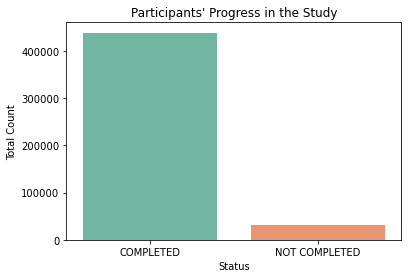

In [338]:
# Filter rows where the 'Title' column is either 'COMPLETED' or 'NOT COMPLETED'
status_filtered = status_sum[status_sum['Status'].isin(['COMPLETED', 'NOT COMPLETED'])]

# Plot a barplot
sns.barplot(x='Status', y='TotalSum', data=status_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total Count')
plt.show()


### Preprocess the data

In [339]:
# Missing values

vax_trials_with_dropouts.isnull().sum()

NCTId              0
Phase              9
Condition          0
EnrollmentCount    0
OverallStatus      0
Reason             0
DropoutCount       0
dtype: int64

In [340]:
# Select the variables for further analysis

cols = ['NCTId', 'Reason', 'Condition']
df = vax_trials_with_dropouts[cols].dropna()
df.shape 

(2809, 3)

In [341]:
df.head()

,NCTId,Reason,Condition
0,NCT02915302,adverse event,Influenza
1,NCT02915302,adverse event,Influenza
2,NCT02915302,protocol violation/deviation,Influenza
3,NCT02915302,protocol violation/deviation,Influenza
4,NCT02915302,lost to follow-up,Influenza


In [342]:
# dummy variables
df = pd.get_dummies(df, columns=['Reason', 'Condition'], prefix=['Reason', 'Condition'])
df.head()

,NCTId,Reason_administrative reason,Reason_adverse event,Reason_ae or death,Reason_baseline measles measure high,Reason_baseline measure non-negative,Reason_case report forms uncollected,Reason_change in cll treatment,Reason_child relocated,Reason_clinical hold,...,Condition_Streptococcal Infections|Gram-Positive Bacterial Infections|Bacterial Infections,Condition_Streptococcal Infection|Gram-positive Bacterial Infection|Bacterial Infection,Condition_Tetanus|Diphtheria|Pertussis|Whooping Cough,Condition_Tularemia,Condition_Vaccine Response Impaired,"Condition_Vaccines, Pneumococcal","Condition_Vaccines, Pneumococcal Conjugate Vaccine",Condition_Virus Diseases|RNA Virus Infections|Respiratory Tract Diseases|Respiratory Tract Infections,Condition_Virus Diseases|RNA Virus Infections|Respiratory Tract Diseases|Respiratory Tract Infections|Influenza,Condition_West Nile Fever
0,NCT02915302,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NCT02915302,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
